In [2]:
# In this assingnment, we will be using Pandas dataframes
# to read, transform, and store MNIST images. Make sure
# you are familiar with its API:
# https://pandas.pydata.org/pandas-docs/stable/

import pandas as pd

In [3]:
# Enter here the Dataset ID that you have received in the spreadsheet.
# Make sure that you use the ID that was assigned to you, 
# otherwise your submission will be graded against the wrong images.
dataset_id = '20240929-164257_8e4b1d415611f51f3ede01d595802ec2'

# Assignment datasets are stored in an AWS S3 bucket. The following code
# downloads your dataset (~300MB) directly into RAM. Optionally,
# you can save the datasets to the local disk, but that's really not required.
prefix = f'https://danylo-ucla.s3-us-west-2.amazonaws.com/app/storage/mnist/jobs/transform_repack/{dataset_id}'

# These three dataframes contain clean images. Use each dataframe
# to train, validate, and test your model, respectively.
train_clean_X = pd.read_parquet(f'{prefix}/train_clean_x.parquet')
validate_clean_X = pd.read_parquet(f'{prefix}/validate_clean_x.parquet')
test_clean_X = pd.read_parquet(f'{prefix}/test_clean_x.parquet')

# These dataframes are noisy versions of the dataframes above.
train_noisy_X = pd.read_parquet(f'{prefix}/train_noisy_x.parquet')
validate_noisy_X = pd.read_parquet(f'{prefix}/validate_noisy_x.parquet')
test_noisy_X = pd.read_parquet(f'{prefix}/test_noisy_x.parquet')

# This is the segment of the dataset that will be graded in this assignment.
# Your model has to denoise this dataframe, and you have to submit the denoised version of this dataframe.
score_noisy_X = pd.read_parquet(f'{prefix}/score_noisy_x.parquet')

# For additional context, these are labels (e.g. digits) corresponding
# to each image in the dataset. Use it to analyze which digits
# your models has more or less problems with. These dataframes
# should not be used as part of the training process itself,
# only for post-training analysis, if you wish so.
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

In [4]:
# While not strictly required for this assignment,
# you will probably want to plot images to
# have a visual understanding of the model's performance.
# You can use any Python plotting library, for example:
# https://matplotlib.org/contents.html

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [5]:
# import numpy as np

# The example in this notebook trains an undercomplete
# autoencoder and uses it for anomaly detection.
# An anomaly is defined as an image with Gaussian noise.
# Therefore, the label is 1 if the image came from the noisy dataset.

# def combine_anomaly_dataset(clean_X: np.ndarray, noisy_X: np.ndarray) -> np.ndarray:
#     anomaly_y = np.hstack([
#         n  noisy_X.shape[0]),  # label
#     ])

#     anomaly_X = np.vstack([
#         clean_X,  # data
#         noisy_X,  # data
#     ])

#     return anomaly_X, anomaly_y


# train_anomaly_X, train_anomaly_y = combine_anomaly_dataset(train_clean_X, train_noisy_X)
# validate_anomaly_X, validate_anomaly_y = combine_anomaly_dataset(validate_clean_X, validate_noisy_X)
# train_anomaly_X.shape, validate_anomaly_X.shape, train_anomaly_y.shape

In [6]:
# Just as in the lecture slides, the input matrix
# has row vectors that hold pixels of a single 28x28 image.
# Note that the column vectors are individual locations on
# the 28x28 grid, but flattened in a row-major way (28x28=784).
train_clean_X.shape

(49000, 784)

In [7]:
example_id = 1

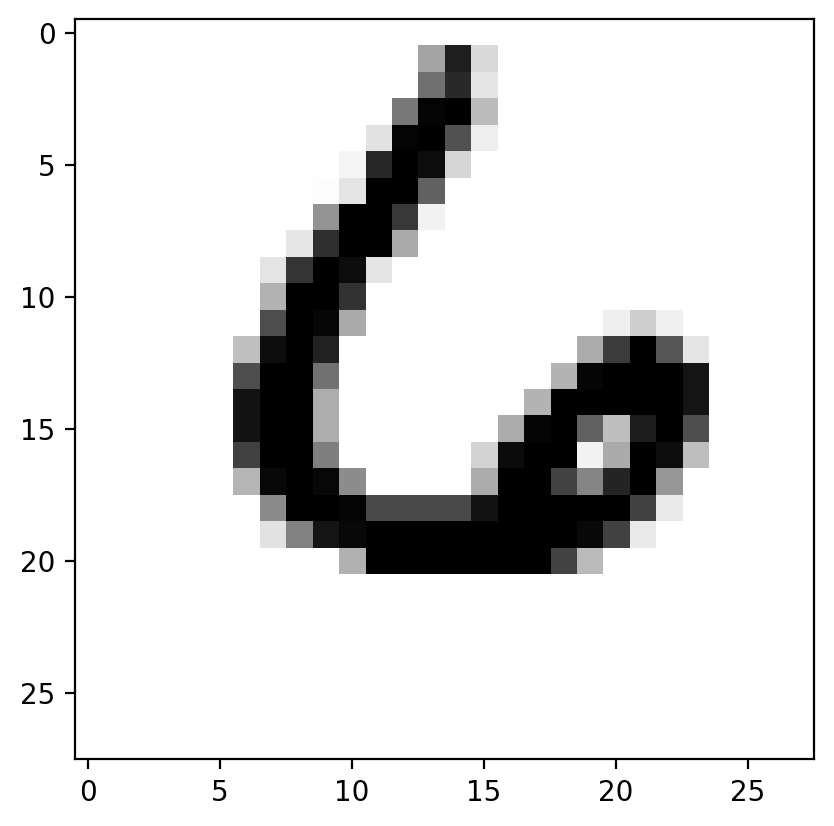

In [8]:
# Let's select a clean image from the dataset
image_pixels = train_clean_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

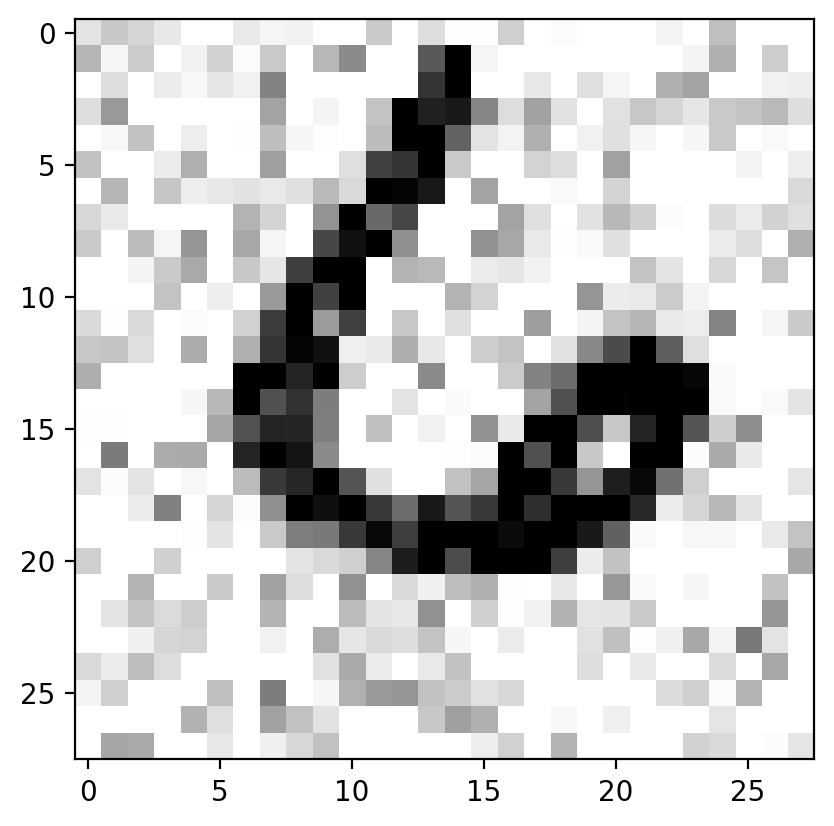

In [9]:
# Let's select a noisy image from the dataset
image_pixels = train_noisy_X.iloc[example_id]

# In order to plot an image, you need to reshape
# the flattened array back into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')

In [10]:
train_y.iloc[example_id]


digit    6
Name: 1, dtype: uint8

In [11]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout,LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.initializers import HeNormal
def build_model(encoder_width: int, learning_rate_log: float) -> tf.keras.Model:
    mlflow.log_param('encoder_width', encoder_width)
    mlflow.log_param('learning_rate_log', learning_rate_log)
    
    # IMPORTANT: This is an example of a very simple undercomplete autoencoder.
    # In other words, you will probably need to tweak these lines of code.
    
    layers = [
        # Encoder: 50 nodes, Gaussian Error Linear Unit activation
        Dense(
            units=encoder_width, 
            activation='gelu', 
            input_shape=(28 * 28,)
        ),
        BatchNormalization(),
        # Decoder: matches the shape of the image
        # Sigmoid activation is needed because pixel
        # values are real numbers between 0 (dark) and 1 (bright).
        Dense(units=28*28, activation='sigmoid')
    ]

    # Sequential class is a Keras class that attaches every 
    # layer's output to the next layer's input.
    # This is essentially a helper class for any feedforward networks.
    autoencoder = Sequential(layers)

    # Using MSE as the loss function, and Adam optimizer.
    # Other optimizers can also be used.
    autoencoder.compile(
        optimizer=optimizers.Adam(learning_rate=float(10 ** learning_rate_log),
        )
        , loss='mean_squared_error',
    )
    return autoencoder


In [ ]:
### TEST OF DIFFERENT ACTIVATION FUNCTION

# def build_model(encoder_width: int, learning_rate_log: float) -> tf.keras.Model:
#     # Build a deeper fully connected autoencoder with additional hidden layers
#     layers = [
#         # Encoder layers
#         Dense(units=encoder_width * 4, activation='relu', input_shape=(28 * 28,)),
#         Dense(units=encoder_width * 2, activation='relu'),
#         Dense(units=encoder_width, activation='relu'),

#         # Decoder layers
#         Dense(units=encoder_width * 2, activation='relu'),
#         Dense(units=encoder_width * 4, activation='relu'),
#         Dense(units=28 * 28, activation='sigmoid')  # Output layer matches input shape
#     ]

#     # Initialize the autoencoder with a sequential model
#     autoencoder = Sequential(layers)

#     # Compile the model with a lower learning rate
#     autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_log), loss='mean_squared_error')
#     return autoencoder

In [14]:
import json
import uuid
import os

# This function will be used to save each trained model.
def save_model(model: tf.keras.Model, model_path: str):
    os.makedirs(model_path, exist_ok=True)
    tf.keras.models.save_model(model, f'{model_path}/model.keras')
    with open(f'{model_path}/architecture.json', 'w') as f:
        f.write(json.dumps(json.loads(model.to_json()), indent=True))


# This function can be used to load a previously trained model.
def load_model(model_path: str) -> tf.keras.Model:
    return tf.keras.models.load_model(f'{model_path}/model.keras')

In [15]:
# IMPORTANT: This is an example of a reconstruction training mode.
# Your autoencoder has to be trained in denoising mode.
# In other words, you will probably need to tweak these lines of code.
from collegium.foundation.callbacks import MlflowCallback
import tempfile


def train_denoise_model(model: tf.keras.Model, epochs: int, verbose: int = 10) -> tf.keras.callbacks.History:
    history = model.fit(
        x=train_noisy_X.values,  
        y=train_clean_X.values, 

        epochs=epochs,  
        batch_size=128, 
        shuffle=True,  
        validation_data=(validate_noisy_X.values, validate_clean_X.values), 
        callbacks=[MlflowCallback()], 
        verbose=verbose  
    )
    
   
    with tempfile.TemporaryDirectory('wb') as d:
        model_path = f'{d}/model'
        save_model(model, model_path)
        mlflow.log_artifacts(d)
    
    return history

In [16]:
# See MLFlow docs for more API examples.
# https://mlflow.org/docs/latest/python_api/mlflow.html

import mlflow
mlflow.set_experiment('assignment_01')
mlflow.tensorflow.autolog(log_models=False, log_input_examples=False, log_model_signatures=False, silent=True)

In [17]:
mlflow.get_experiment_by_name('assignment_01')

<Experiment: artifact_location='file:///app/mlflow/315376735214207906', creation_time=1728255608366, experiment_id='315376735214207906', last_update_time=1728255608366, lifecycle_stage='active', name='assignment_01', tags={}>

In [85]:
# In order to have reproducible results, we need
# to set the seed values for NumPy and Tensorflow.
# Keep these lines in the same cell as the training code,
# so that you don't accidentally train multiples models

## TESTING THE FUNCTION WITH PARAMETERS

import numpy as np
import tensorflow as tf
import mlflow

# Setting the seeds for reproducibility without resetting later
np.random.seed(11)
tf.random.set_seed(11)

# Assuming you have your model-building and training functions defined
# build_model() and train_denoise_model() should already exist

with mlflow.start_run():
    autoencoder = build_model(encoder_width=300, learning_rate_log=-2.8)
    history = train_denoise_model(autoencoder, epochs=30)

    # Logging the loss at each epoch
    for epoch, loss in enumerate(history.history['loss']):
        print(f"Epoch {epoch + 1}, Loss: {loss}")
        mlflow.log_metric("loss", loss, step=epoch + 1)

    # Optionally, you can log the final model
    mlflow.keras.log_model(autoencoder, "autoencoder_model")


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
Epoch 1, Loss: 0.03033389523625374
Epoch 2, Loss: 0.00504196947440505
Epoch 3, Loss: 0.0043021864257752895
Epoch 4, Loss: 0.004029055591672659
Epoch 5, Loss: 0.0038924789987504482
Epoch 6, Loss: 0.003806525142863393
Epoch 7, Loss: 0.0037502506747841835
Epoch 8, Loss: 0.0037086396478116512
Epoch 9, Loss: 0.0036652283743023872
Epoch 10, Loss: 0.003655647858977318
Epoch 11, Loss: 0.0036120659206062555
Epoch 12, Loss: 0.0035835641901940107
Epoch 13, Loss: 0.0035838631447404623
Epoch 14, Loss: 0.003549770452082157
Epoch 15, Loss: 0.003547730389982462
Epoch 16, Loss: 0.0035287674982100725
Epoch 17, Loss: 0.0035119005478918552
Epoch 18, Loss: 0.003

2024/10/06 22:39:18 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Epoch 23, Loss: 0.0034533010330051184
Epoch 24, Loss: 0.0034378126729279757
Epoch 25, Loss: 0.0034296608064323664
Epoch 26, Loss: 0.0034135004971176386
Epoch 27, Loss: 0.0034116837196052074
Epoch 28, Loss: 0.0033956218976527452
Epoch 29, Loss: 0.003385807853192091
Epoch 30, Loss: 0.0033916672691702843
INFO:tensorflow:Assets written to: /tmp/tmp_ap9n2wk/model/data/model/assets


2024/10/06 22:39:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
# train_reconstructed_X = autoencoder.predict(train_anomaly_X)
# train_reconstruction_loss = ((train_anomaly_X - train_reconstructed_X) ** 2).sum(axis=1)
# train_reconstruction_loss.shape

In [ ]:
# np.corrcoef(train_reconstruction_loss, train_anomaly_y)

In [ ]:
# train_anomaly_y_hat = (train_reconstruction_loss > train_reconstruction_loss.mean())
# (train_anomaly_y == train_anomaly_y_hat).mean()

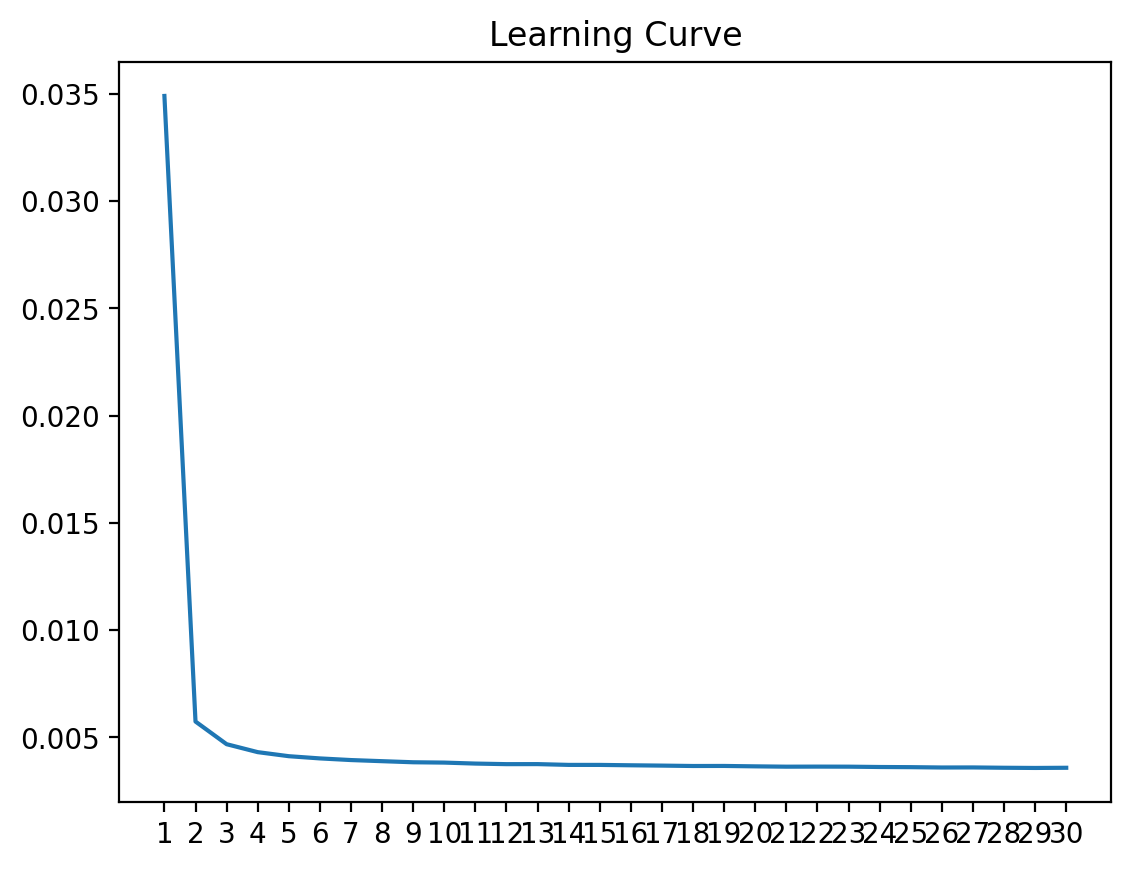

In [80]:
# The fit method returns a history object that
# can be used to plot the learning curve.

learning_curve = pd.Series(history.history['loss'])
learning_curve.index = learning_curve.index + 1

learning_curve.plot(title='Learning Curve')
plt.xticks(learning_curve.index)
plt.show()

In [87]:
########## LOOP FOR FINDING THE BEST MODEL ###################

import random
import tqdm

runs = 10
learning_rate_logs = [random.uniform(-2.5, -3.5) for _ in range(runs)]
encoder_widths = [random.choice(range(200, 300, 5)) for _ in range(runs)]
parameters = list(zip(learning_rate_logs, encoder_widths))

for (learning_rate_log, encoder_width) in tqdm.tqdm(parameters):
    with mlflow.start_run():
        autoencoder = build_model(encoder_width=encoder_width, learning_rate_log=learning_rate_log)
        history = train_denoise_model(autoencoder, epochs=25, verbose=0)
        # Logging the loss at each epoch
        for epoch, loss in enumerate(history.history['loss']):
            print(f"Epoch {epoch + 1}, Loss: {loss}")
            mlflow.log_metric("loss", loss, step=epoch + 1)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 0.03635683283209801
Epoch 2, Loss: 0.005730335600674152
Epoch 3, Loss: 0.004652978852391243
Epoch 4, Loss: 0.004277779255062342
Epoch 5, Loss: 0.004075293894857168
Epoch 6, Loss: 0.003966288175433874
Epoch 7, Loss: 0.003884769743308425
Epoch 8, Loss: 0.0038328412920236588
Epoch 9, Loss: 0.0037844849284738302
Epoch 10, Loss: 0.0037668724544346333
Epoch 11, Loss: 0.0037228467408567667
Epoch 12, Loss: 0.003694400191307068
Epoch 13, Loss: 0.00369222741574049
Epoch 14, Loss: 0.0036553849931806326
Epoch 15, Loss: 0.003659042064100504
Epoch 16, Loss: 0.003639449132606387
Epoch 17, Loss: 0.003624631091952324
Epoch 18, Loss: 0.0036046046297997236
Epoch 19, Loss: 0.003608469385653734
Epoch 20, Loss: 0.0035892187152057886
Epoch 21, Loss: 0.0035746723879128695
Epoch 22, Loss: 0.003576933639124036
Epoch 23, Loss: 0.0035736672580242157
Epoch 24, Loss: 0.0035612776409834623


 10%|█         | 1/10 [01:04<09:37, 64.17s/it]

Epoch 25, Loss: 0.0035518051590770483
Epoch 1, Loss: 0.053586237132549286
Epoch 2, Loss: 0.006944824941456318
Epoch 3, Loss: 0.005071193911135197
Epoch 4, Loss: 0.004452126566320658
Epoch 5, Loss: 0.004156031180173159
Epoch 6, Loss: 0.003983350936323404
Epoch 7, Loss: 0.003874637885019183
Epoch 8, Loss: 0.003795142285525799
Epoch 9, Loss: 0.0037306782323867083
Epoch 10, Loss: 0.0036994884721934795
Epoch 11, Loss: 0.003647002624347806
Epoch 12, Loss: 0.0036123243626207113
Epoch 13, Loss: 0.0036038397811353207
Epoch 14, Loss: 0.003565259976312518
Epoch 15, Loss: 0.003563443198800087
Epoch 16, Loss: 0.003536080475896597
Epoch 17, Loss: 0.0035202419385313988
Epoch 18, Loss: 0.003505624597892165
Epoch 19, Loss: 0.003498750040307641
Epoch 20, Loss: 0.00348197715356946
Epoch 21, Loss: 0.003467945847660303
Epoch 22, Loss: 0.0034682133700698614
Epoch 23, Loss: 0.003461340442299843
Epoch 24, Loss: 0.003451985539868474


 20%|██        | 2/10 [02:11<08:49, 66.21s/it]

Epoch 25, Loss: 0.0034413589164614677
Epoch 1, Loss: 0.041173554956912994
Epoch 2, Loss: 0.006249562371522188
Epoch 3, Loss: 0.004879130981862545
Epoch 4, Loss: 0.0044034807942807674
Epoch 5, Loss: 0.004171370062977076
Epoch 6, Loss: 0.004032977856695652
Epoch 7, Loss: 0.003948869649320841
Epoch 8, Loss: 0.003879311727359891
Epoch 9, Loss: 0.0038227869663387537
Epoch 10, Loss: 0.0038019251078367233
Epoch 11, Loss: 0.003752603428438306
Epoch 12, Loss: 0.0037235496565699577
Epoch 13, Loss: 0.003723858157172799
Epoch 14, Loss: 0.0036864469293504953
Epoch 15, Loss: 0.003685441566631198
Epoch 16, Loss: 0.003667158540338278
Epoch 17, Loss: 0.003650675294920802
Epoch 18, Loss: 0.003632172243669629
Epoch 19, Loss: 0.0036348055582493544
Epoch 20, Loss: 0.003615632653236389
Epoch 21, Loss: 0.00360177387483418
Epoch 22, Loss: 0.003604826983064413


 30%|███       | 3/10 [03:14<07:31, 64.47s/it]

Epoch 23, Loss: 0.0036028248723596334
Epoch 24, Loss: 0.0035900489892810583
Epoch 25, Loss: 0.003582725999876857
Epoch 1, Loss: 0.032455701380968094
Epoch 2, Loss: 0.005275481380522251
Epoch 3, Loss: 0.00445083063095808
Epoch 4, Loss: 0.004116937518119812
Epoch 5, Loss: 0.003962599206715822
Epoch 6, Loss: 0.003870217828080058
Epoch 7, Loss: 0.0038081668317317963
Epoch 8, Loss: 0.0037566761020570993
Epoch 9, Loss: 0.0037122017238289118
Epoch 10, Loss: 0.0037017527502030134
Epoch 11, Loss: 0.003658297238871455
Epoch 12, Loss: 0.0036302581429481506
Epoch 13, Loss: 0.0036353927571326494
Epoch 14, Loss: 0.0035951132886111736
Epoch 15, Loss: 0.003594150533899665
Epoch 16, Loss: 0.0035765490029007196
Epoch 17, Loss: 0.0035617027897387743
Epoch 18, Loss: 0.0035421911161392927
Epoch 19, Loss: 0.0035442959051579237
Epoch 20, Loss: 0.003522211220115423
Epoch 21, Loss: 0.0035076476633548737
Epoch 22, Loss: 0.003511055139824748
Epoch 23, Loss: 0.0035077431239187717


 40%|████      | 4/10 [04:21<06:33, 65.63s/it]

Epoch 24, Loss: 0.0034935730509459972
Epoch 25, Loss: 0.00348683912307024
Epoch 1, Loss: 0.09190890938043594
Epoch 2, Loss: 0.011958738788962364
Epoch 3, Loss: 0.007400370668619871
Epoch 4, Loss: 0.005754651967436075
Epoch 5, Loss: 0.004973052069544792
Epoch 6, Loss: 0.004541928879916668
Epoch 7, Loss: 0.004276175983250141
Epoch 8, Loss: 0.004092358984053135
Epoch 9, Loss: 0.003958167973905802
Epoch 10, Loss: 0.0038919574581086636
Epoch 11, Loss: 0.0037992852739989758
Epoch 12, Loss: 0.0037376226391643286
Epoch 13, Loss: 0.003714420832693577
Epoch 14, Loss: 0.0036559489089995623
Epoch 15, Loss: 0.003637039801105857
Epoch 16, Loss: 0.0036046572495251894
Epoch 17, Loss: 0.003580744145438075
Epoch 18, Loss: 0.0035505425184965134
Epoch 19, Loss: 0.003542101476341486
Epoch 20, Loss: 0.0035224640741944313
Epoch 21, Loss: 0.003500542137771845
Epoch 22, Loss: 0.0034951427951455116
Epoch 23, Loss: 0.0034870533272624016
Epoch 24, Loss: 0.003473017830401659
Epoch 25, Loss: 0.0034608817659318447


 50%|█████     | 5/10 [05:29<05:32, 66.48s/it]

Epoch 1, Loss: 0.05627427622675896
Epoch 2, Loss: 0.007634974084794521
Epoch 3, Loss: 0.005455246195197105
Epoch 4, Loss: 0.0046992115676403046
Epoch 5, Loss: 0.004341974854469299
Epoch 6, Loss: 0.004148256499320269
Epoch 7, Loss: 0.0040196520276367664
Epoch 8, Loss: 0.003919246606528759
Epoch 9, Loss: 0.0038572363555431366
Epoch 10, Loss: 0.003821262391284108
Epoch 11, Loss: 0.0037562688812613487
Epoch 12, Loss: 0.003723243484273553
Epoch 13, Loss: 0.0037159984931349754
Epoch 14, Loss: 0.003673447296023369
Epoch 15, Loss: 0.0036634784191846848
Epoch 16, Loss: 0.0036393050104379654
Epoch 17, Loss: 0.0036226455122232437
Epoch 18, Loss: 0.0036026067100465298
Epoch 19, Loss: 0.003601707983762026
Epoch 20, Loss: 0.003585244994610548
Epoch 21, Loss: 0.003569390159100294
Epoch 22, Loss: 0.0035713440738618374
Epoch 23, Loss: 0.0035661354195326567
Epoch 24, Loss: 0.0035555080976337194


 60%|██████    | 6/10 [06:31<04:19, 64.75s/it]

Epoch 25, Loss: 0.0035433275625109673
Epoch 1, Loss: 0.02655264176428318
Epoch 2, Loss: 0.004943976178765297
Epoch 3, Loss: 0.004301818553358316
Epoch 4, Loss: 0.00404240982607007
Epoch 5, Loss: 0.003916991874575615
Epoch 6, Loss: 0.0038449594285339117
Epoch 7, Loss: 0.0037854542024433613
Epoch 8, Loss: 0.003747934475541115
Epoch 9, Loss: 0.0037028351798653603
Epoch 10, Loss: 0.003693872829899192
Epoch 11, Loss: 0.0036574292462319136
Epoch 12, Loss: 0.0036259195767343044
Epoch 13, Loss: 0.0036262902431190014
Epoch 14, Loss: 0.0035911020822823048
Epoch 15, Loss: 0.003589032916352153
Epoch 16, Loss: 0.003571524517610669
Epoch 17, Loss: 0.0035531283356249332
Epoch 18, Loss: 0.0035320830065757036
Epoch 19, Loss: 0.0035349149256944656
Epoch 20, Loss: 0.0035121312830597162
Epoch 21, Loss: 0.003493687603622675
Epoch 22, Loss: 0.0034972450230270624
Epoch 23, Loss: 0.0034918799065053463
Epoch 24, Loss: 0.0034741105046123266
Epoch 25, Loss: 0.0034662154503166676


 70%|███████   | 7/10 [07:39<03:17, 65.82s/it]

Epoch 1, Loss: 0.0977114886045456
Epoch 2, Loss: 0.012705574743449688
Epoch 3, Loss: 0.007729969918727875
Epoch 4, Loss: 0.0059333182871341705
Epoch 5, Loss: 0.0050826347433030605
Epoch 6, Loss: 0.0046123331412673
Epoch 7, Loss: 0.004320207051932812
Epoch 8, Loss: 0.004126543179154396
Epoch 9, Loss: 0.003981550224125385
Epoch 10, Loss: 0.0039015759248286486
Epoch 11, Loss: 0.0038074138574302197
Epoch 12, Loss: 0.0037404047325253487
Epoch 13, Loss: 0.0037152760196477175
Epoch 14, Loss: 0.0036515993997454643
Epoch 15, Loss: 0.003633383195847273
Epoch 16, Loss: 0.0036018097307533026
Epoch 17, Loss: 0.003571602748706937
Epoch 18, Loss: 0.003542878432199359
Epoch 19, Loss: 0.0035352425184100866
Epoch 20, Loss: 0.0035087508149445057
Epoch 21, Loss: 0.003490554867312312
Epoch 22, Loss: 0.0034834961406886578
Epoch 23, Loss: 0.0034732664935290813


 80%|████████  | 8/10 [08:48<02:13, 66.85s/it]

Epoch 24, Loss: 0.0034587346017360687
Epoch 25, Loss: 0.00344793195836246
Epoch 1, Loss: 0.028628922998905182
Epoch 2, Loss: 0.00514214625582099
Epoch 3, Loss: 0.004390028305351734
Epoch 4, Loss: 0.004113900475203991
Epoch 5, Loss: 0.003970736172050238
Epoch 6, Loss: 0.0038878093473613262
Epoch 7, Loss: 0.0038250405341386795
Epoch 8, Loss: 0.003782817395403981
Epoch 9, Loss: 0.0037375749088823795
Epoch 10, Loss: 0.003727897070348263
Epoch 11, Loss: 0.0036910923663526773
Epoch 12, Loss: 0.0036601105239242315
Epoch 13, Loss: 0.003663039766252041
Epoch 14, Loss: 0.003627025056630373
Epoch 15, Loss: 0.0036244678776711226
Epoch 16, Loss: 0.0036060514394193888
Epoch 17, Loss: 0.003589300438761711
Epoch 18, Loss: 0.0035680474247783422
Epoch 19, Loss: 0.0035721641033887863
Epoch 20, Loss: 0.00354798324406147
Epoch 21, Loss: 0.003534268354997039
Epoch 22, Loss: 0.0035362655762583017
Epoch 23, Loss: 0.003531842492520809
Epoch 24, Loss: 0.0035170752089470625


 90%|█████████ | 9/10 [09:55<01:07, 67.14s/it]

Epoch 25, Loss: 0.0035076166968792677
Epoch 1, Loss: 0.05604991316795349
Epoch 2, Loss: 0.00739864818751812
Epoch 3, Loss: 0.005317073781043291
Epoch 4, Loss: 0.004594671539962292
Epoch 5, Loss: 0.004270191304385662
Epoch 6, Loss: 0.004075499251484871
Epoch 7, Loss: 0.003953184001147747
Epoch 8, Loss: 0.0038704578764736652
Epoch 9, Loss: 0.003800389589741826
Epoch 10, Loss: 0.0037666161078959703
Epoch 11, Loss: 0.003709075041115284
Epoch 12, Loss: 0.003668943652883172
Epoch 13, Loss: 0.0036645049694925547
Epoch 14, Loss: 0.003620675764977932
Epoch 15, Loss: 0.0036166461650282145
Epoch 16, Loss: 0.003590601496398449
Epoch 17, Loss: 0.003576155286282301
Epoch 18, Loss: 0.0035547406878322363
Epoch 19, Loss: 0.0035528000444173813
Epoch 20, Loss: 0.003535541705787182
Epoch 21, Loss: 0.003520081751048565


100%|██████████| 10/10 [11:03<00:00, 66.31s/it]

Epoch 22, Loss: 0.003522521583363414
Epoch 23, Loss: 0.003515513613820076
Epoch 24, Loss: 0.0035019649658352137
Epoch 25, Loss: 0.003495663171634078


In [ ]:
####################### LAST RUN NOT NEEDED ##########################

# # This loads the last active run,
# # but you probably want to load the best run from the experiment.
# last_run = mlflow.last_active_run()
# saved_model_path = mlflow.tracking.MlflowClient().download_artifacts(last_run.info.run_id, 'model')
# autoencoder = load_model(saved_model_path)

In [103]:
############## BEST MODEL FROM THE LOOP ##############

## Load the best match from the loop 
from mlflow.tracking import MlflowClient

# Initialize the MLflow client
client = MlflowClient()

# Get all runs from the experiment
experiment_id = client.get_experiment_by_name('assignment_01').experiment_id
runs = client.search_runs(experiment_id, order_by=["metrics.val_loss ASC"], max_results=1)

# Retrieve the best run based on validation loss
best_run = runs[0]
print(f"Best run ID: {best_run.info.run_id} with validation loss: {best_run.data.metrics['val_loss']}")
print(f"parameter: {best_run.data.params['learning_rate_log']} ")
print(f"parameter: {best_run.data.params['encoder_width']}")

# Download the artifacts of the best run
saved_model_path = client.download_artifacts(best_run.info.run_id, 'model')
autoencoder = load_model(saved_model_path)

Best run ID: 26014aba5d154d1f80f587ee6b6e3165 with validation loss: 0.0034494835417717695
parameter: -3.4828336462082614 
parameter: 260


In [ ]:
## BEST MODEL PARAMETERS

# Best run ID: 26014aba5d154d1f80f587ee6b6e3165 with validation loss: 0.0034494835417717695
# parameter: -3.4828336462082614 
# parameter: 260

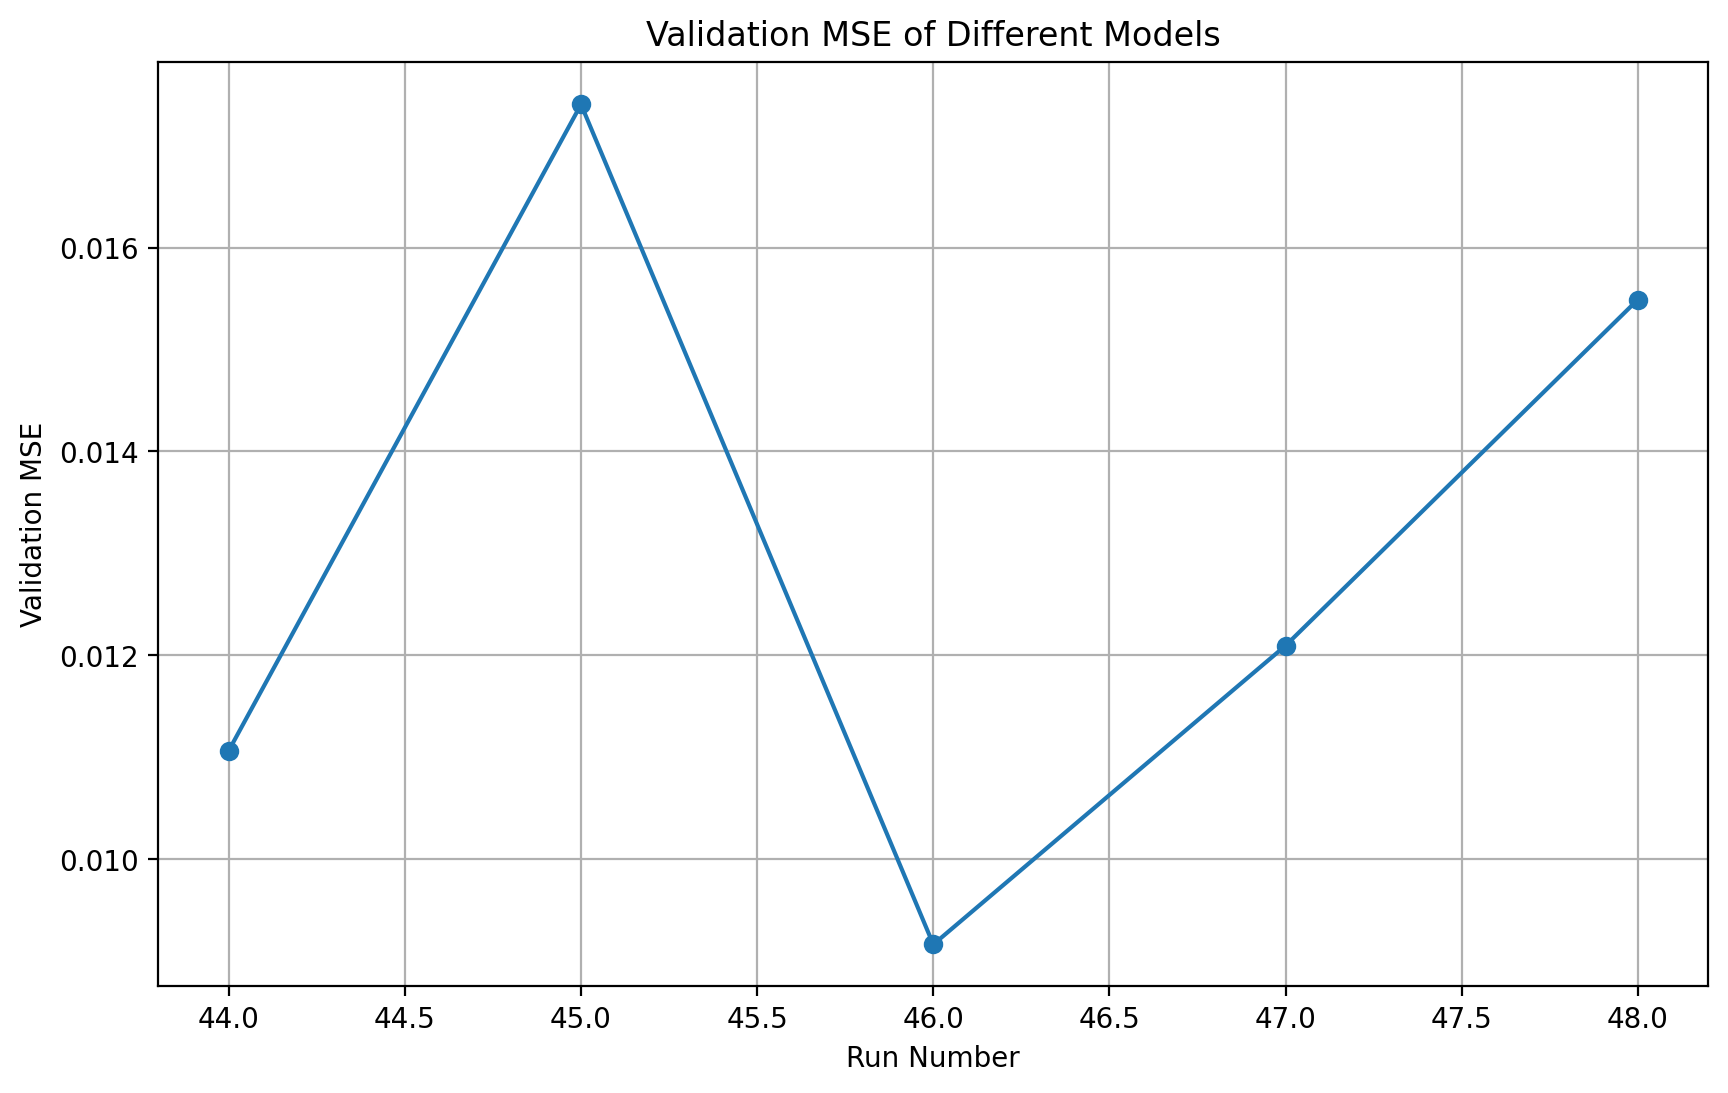

In [88]:
# ########### PLOTTING THE BEST MODEL WITH MSE IN THE GRAPH ###################

import mlflow
from mlflow.tracking import MlflowClient
import matplotlib.pyplot as plt

# Initialize the MLflow client
client = MlflowClient()

# Get all runs for the current experiment
experiment_id = client.get_experiment_by_name('assignment_01').experiment_id
runs = client.search_runs(experiment_id)

# Extract MSE values and their corresponding hyperparameters
mse_values = []
encoder_widths = []
learning_rate_logs = []

for run in runs:
    mse_values.append(run.data.metrics.get('mse_validate'))
    encoder_widths.append(run.data.params.get('encoder_width'))
    learning_rate_logs.append(run.data.params.get('learning_rate_log'))

# Plot the MSE values
plt.figure(figsize=(10, 6))
plt.plot(mse_values, marker='o')
plt.xlabel('Run Number')
plt.ylabel('Validation MSE')
plt.title('Validation MSE of Different Models')
plt.grid(True)
plt.show()


In [104]:
# Now we can feed the noisy images into the autoencoder.
train_denoised_X = autoencoder.predict(train_noisy_X)

# Keras returns back a Numpy array, but we need Pandas dataframe,
# so let's quickly put the denoised images into a dataframe.
train_denoised_X = pd.DataFrame(train_denoised_X)

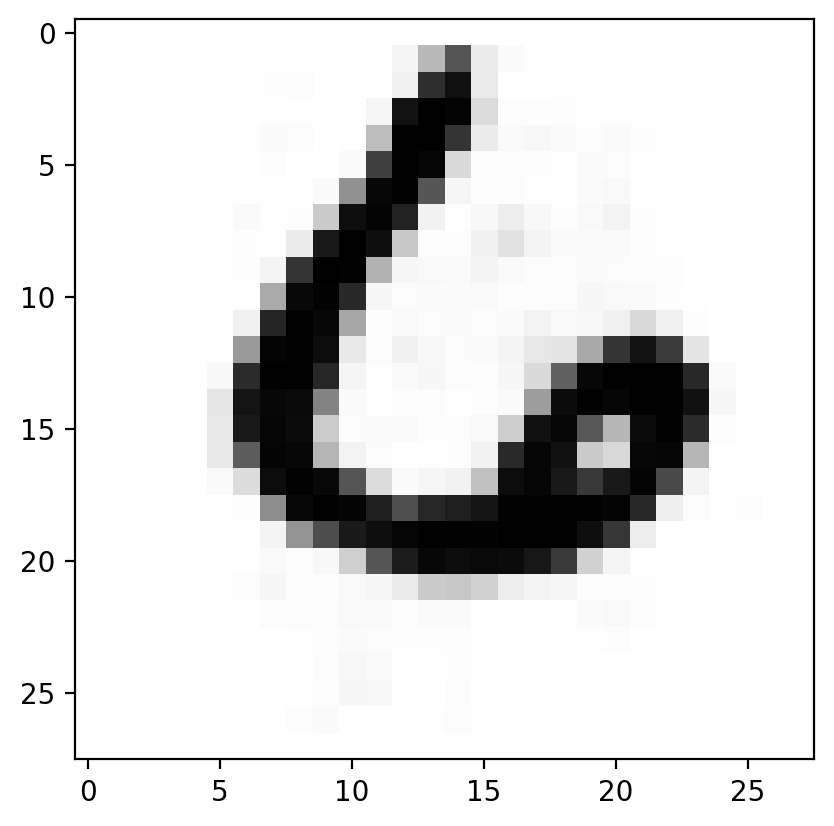

In [105]:
# Let's confirm that the denoiser works.
image_pixels = train_denoised_X.iloc[example_id]

# In order to plot an image, you need to reshape

# the array into a 28x28 grid.
image_pixels = image_pixels.values.reshape(28, 28)

plt.imshow(image_pixels, cmap='binary')
plt.show()

In [106]:
# To calculate MSE between two datasets we can use scikit-learn:
# https://scikit-learn.org/stable/
from sklearn.metrics import mean_squared_error

# This calcualates MSE on train clean against train denoised,
# which measures how well the autoencoder denoises the training dataset.
# Note that you really want to calculate this metric on validate and/or test dataset.
# Don't let an overfitting model fool you into using it for the graded submission!
mean_squared_error(train_denoised_X, train_clean_X)

0.0030784528

In [109]:
## TEST DATASET Testing the model


test_denoised_X = autoencoder.predict(test_noisy_X)
mse_test = mean_squared_error(test_denoised_X, test_clean_X)
print(f'Test MSE: {mse_test}')


Test MSE: 0.003433933714404702


In [116]:
import os 

model_path = 'assignment_submission'

os.makedirs(model_path, exist_ok=True)

# Once you are ready to make the graded submission,
# run the autoencoder on the score noisy dataset.
score_denoised_X = pd.DataFrame(
    autoencoder.predict(score_noisy_X),
    # This is needed to save the file in Parquet format.
    columns=score_noisy_X.columns
)

# Now save it to disc as a Parquet file.
score_denoised_X.to_parquet(f'{model_path}/score_denoised_x.parquet')

save_model(autoencoder, model_path)

# You now have the following files to be uploaded:
# 1. This notebook and any other Python code you used to train the final model.
# 2. architecture.json -- the model's definition
# 3. model.keras -- the model's trained parameters
# 4. score_denoised_X.parquet - the model's output on the score dataset

In [118]:
print(client.get_run("26014aba5d154d1f80f587ee6b6e3165").data)



<RunData: metrics={'loss': 0.00344793195836246,
 'val_loss': 0.0034494835417717695,
 'validation_loss': 0.0034494835417717695}, params={'batch_size': '128',
 'class_weight': 'None',
 'encoder_width': '260',
 'epochs': '25',
 'initial_epoch': '0',
 'learning_rate_log': '-3.4828336462082614',
 'max_queue_size': '10',
 'opt_amsgrad': 'False',
 'opt_beta_1': '0.9',
 'opt_beta_2': '0.999',
 'opt_decay': '0.0',
 'opt_epsilon': '1e-07',
 'opt_learning_rate': '0.0003289776195695425',
 'opt_name': 'Adam',
 'sample_weight': 'None',
 'shuffle': 'True',
 'steps_per_epoch': 'None',
 'use_multiprocessing': 'False',
 'validation_batch_size': 'None',
 'validation_freq': '1',
 'validation_split': '0.0',
 'validation_steps': 'None',
 'workers': '1'}, tags={'mlflow.latest_checkpoint_artifact': 'checkpoints/latest_checkpoint.h5',
 'mlflow.runName': 'bedecked-bear-333',
 'mlflow.source.name': '/app/conda/envs/collegium/lib/python3.10/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'm